This is my first kernel on Kaggle. I am very excited to contribute to this competition and going back to my days of studying biomechatonics where I first met the concept of feature extraction to classify signals from sensors on human body. 

I made a fast literature review on feature extraction and signal classification and prepared following experiment for my first submissions.

I will be updating explanatory walktrough alongside model improvements.

Running and submitting from full notebook on interactive session was problemmatic due to memory troubles with the test set. I will work my way around it meanwhile you can download to use or fork to improve. Open for feedbacks to improve my first kernel.

Have fun everyone!

Many thanks to following kernels:
- For shortening the signals with a simple feature extraction thanks to: https://www.kaggle.com/ashishpatel26/transfer-learning-in-basic-nn
- For signal denoising and fft: https://www.kaggle.com/theoviel/fast-fourier-transform-denoising

In [1]:
import keras
import keras.backend as K
from keras.layers import Layer, LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,Input, Bidirectional, CuDNNLSTM
from keras.models import Sequential, Model
import tensorflow as tf
import gc
from numba import jit
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.model_selection import StratifiedKFold
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sns.set_style("whitegrid")

from kit.feature_extraction import transform_ts, transform_ts_spectrogram

Using TensorFlow backend.


## 0. Info

**Signals:**

- 800.000 measurement points for 8712 signals.
- The signals are **three-phased** so there are 2904 distinct signaling instances.
- Three phase signals:
    - Sums to zero.
    - When one fails other continue to carry the current.
    - Can be rectified to be converted to DC current.
    - Ripples in rectification can be seen on failure.
   

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/3-phase_flow.gif/357px-3-phase_flow.gif)

### What is partial discharge?

 - Typical situation of PD: imagine there is an internal cavity/void or **impurity in insulation**. 
 - When **High Voltage** is applied on conductor, a field is also induced on the cavity. Further, when the field increases, this **defect breaks down** and **discharges** different forms of energy which result in partial discharge.
 - This phenomenon is damaging over a long period of time. It is not event that occurs suddenly. 

### Classical Modes of Detection
- Partial Discharges can be detected by **measuring the emissions** they give off: Ultrasonic Sound, Transient Earth Voltages (TEV and UHF energy).
- Is it possible to enhance the modes of detection by **better feature extraction** for the classifiers?
- **Intel Mobile ODT** challenge on 2017 was about topping **classical image processing** methods by automatic feature extaction using pre-trained CNN models and **transfer learning**.
- **Two possible approaches**:
    - FE on signals and feeding them into NNs for classification.
    - Using NNs further as feature extractors and then use shallow classifiers (XGBoost) for binary classification


### **TASK:** Classify long-term failure of covered conductors based on signal characteristics:
- Extract features from time series data for classification.
- Use **CNN** for further FE and **LSTM** to get temporal dependencies and perform time series classification on the top layer.

## 1. Load Data

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

In [3]:
import os

In [4]:
%%time 
train_set = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 47.9 s, sys: 9.65 s, total: 57.6 s
Wall time: 5.38 s


In [5]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')

CPU times: user 7.29 ms, sys: 730 µs, total: 8.02 ms
Wall time: 9.24 ms


## 2. Process and Minimize Data

In [7]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
#     n_part is the reduced dimension
    lenght = len(x) #full dimension
    pool = np.int32(np.ceil(lenght/n_part)) #bin size
    output1 = np.zeros((n_part,)) #array of zeros of the reduced dimension size
    output2 = np.zeros((n_part,)) #array of zeros of the reduced dimension size
    output3 = np.zeros((n_part,)) #array of zeros of the reduced dimension size
    for j, i in enumerate(range(0,lenght, pool)): #list of tuples i = 0 to red_dim, j = 0 to full_dim BY BIN SIZE)
        if i+pool < lenght:   #when you are not near the end of the array
            k = x[i:i+pool]   #k is from i to i+bin size. however i increments by bin_size. so its no overlap.
        else:                 #close to the end of the array
            k = x[i:]         #k is everything form i till the end of the array, whatever is left... < pool
        output1[j] = np.max(k, axis=0) - np.min(k, axis=0)
#         output2[j] = np.mean(k)
#         output3[j] = np.std(k)
    return output1 #, output2, output3

In [8]:
x_train = []
y_train = []
for i in tqdm(meta_train.signal_id):
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train_set.iloc[:, idx].values, n_part=1000)))

100%|██████████| 8712/8712 [01:49<00:00, 79.70it/s]


/home/adi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in byte_scalars
  


[]

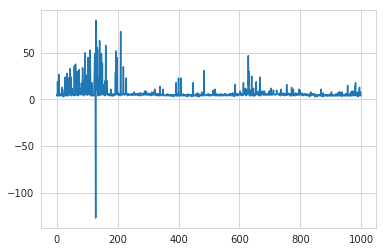

In [9]:
# plt.plot(train_set['3'])
plt.plot(feature_extractor(train_set['3'], n_part = 1000))
plt.plot()

In [10]:
del train_set; gc.collect()

18586

In [11]:
y_train = np.array(y_train).reshape(-1,)
X_train = np.array(x_train).reshape(-1,x_train[0].shape[0])

In [12]:
y_train.shape, X_train.shape

((8712,), (8712, 1000))

## 3. Build Primitive CNN + LSTM Model

* CNN is for feature extraction and LSTM is for capturing time dependency.

In [13]:
sess = None
def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [14]:
def keras_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [15]:
def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

In [16]:
reset_tf()
K.clear_session()

In [17]:
n_signals = 1 #So far each instance is one signal. We will diversify them in next step
n_outputs = 1 #Binary Classification

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=442)

In [19]:
X_train.shape

(8712, 1000)

In [20]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [21]:
def model_A(input_shape):
    inp = Input(shape = (input_shape[1], input_shape[2], 1))
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(inp)
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(x)
    x = TimeDistributed(Dropout(0.5))(x)
    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(100)(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(n_outputs, activation='sigmoid')(x)
    
    model = Model(inputs = inp, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[mcc])
    
    return model

In [22]:
def model_B(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2]))
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [23]:
%%time
i = 0
cv_scores = []
verbose, epochs, batch_size = True, 40, 16
cv_scores = np.zeros((kfold.get_n_splits(), epochs, 2))
for train,test in kfold.split(X_train,y_train):
    print('K-fold {}/{}.....'.format(i+1,kfold.get_n_splits()))
    #Build the model
    n_steps, n_length = 50, 20
    Xtr, Ytr = X_train[train], y_train[train]
    Xte, Yte = X_train[test], y_train[test]
    Xtr = Xtr.reshape((Xtr.shape[0], n_steps, n_length, n_signals))
    Xte = Xte.reshape((Xte.shape[0], n_steps, n_length, n_signals))
    
    model = model_A(X_train.shape)
    
    
    for epch in range(epochs):
        print('-'*10 + 'Master epoch number: {}/{}'.format(epch+1,epochs))
        hist_call = model.fit(Xtr, Ytr, epochs=1, batch_size=batch_size, verbose=verbose)
        mcc_train = hist_call.history['mcc'][0]
        mcc_eval = model.evaluate(Xte, Yte, verbose=verbose)[1]
        print(i,epch)
        cv_scores[i,epch,0] = mcc_train
        cv_scores[i,epch,1] = mcc_eval
        
    i += 1

K-fold 1/5.....


IndexError: tuple index out of range

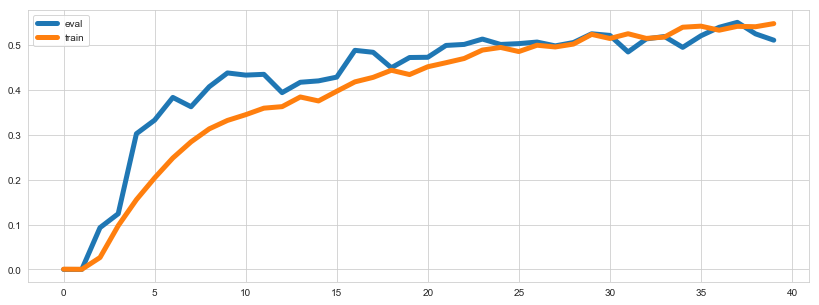

In [492]:
plt.figure(figsize = (14, 5))
plt.plot(np.mean(cv_scores[:,:,1], axis = 0), label = 'eval', linewidth = 5)
plt.plot(np.mean(cv_scores[:,:,0], axis = 0), label = 'train', linewidth = 5)
plt.legend()
plt.show()

In [486]:
model.save_weights('model4_cv.hdf5')

In [30]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6977670286040893429
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17175875415226776932
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6847507164054052944
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1571671981000478803
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799334503
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15984494555689737985
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:a1:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6881571636
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1108660

In [32]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [33]:
verbose, epochs, batch_size = True, 12, 16
n_steps, n_length = 50, 20
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length))

model = model_B(X_train.shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 20)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 256)           152576    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 325,249
Trainable params: 325,249
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train, y_train, epochs=epochs, batch_size=1000, verbose=verbose, validation_split = 0.1)

Train on 7840 samples, validate on 872 samples
Epoch 1/12
7840/7840 [==============================] - 2s 295us/step - loss: 0.0905 - matthews_correlation: 0.7283 - val_loss: 0.1712 - val_matthews_correlation: 0.2039
Epoch 2/12
7840/7840 [==============================] - 2s 287us/step - loss: 0.0819 - matthews_correlation: 0.7379 - val_loss: 0.1690 - val_matthews_correlation: 0.1550
Epoch 3/12
7840/7840 [==============================] - 2s 289us/step - loss: 0.0745 - matthews_correlation: 0.7678 - val_loss: 0.1874 - val_matthews_correlation: 0.1550
Epoch 4/12
7840/7840 [==============================] - 2s 284us/step - loss: 0.0713 - matthews_correlation: 0.7693 - val_loss: 0.1758 - val_matthews_correlation: 0.1735
Epoch 5/12
7840/7840 [==============================] - 2s 291us/step - loss: 0.0663 - matthews_correlation: 0.8058 - val_loss: 0.1851 - val_matthews_correlation: 0.1395
Epoch 6/12
7840/7840 [==============================] - 2s 291us/step - loss: 0.0550 - matthews_correla

In [37]:
%%time
test_set = pq.read_pandas('input/test.parquet').to_pandas()

CPU times: user 1min 58s, sys: 17.4 s, total: 2min 15s
Wall time: 11.7 s


In [38]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.2 ms


In [ ]:
x_test = []
for i in tqdm(meta_test.signal_id.values):
   idx=i-8712
   clear_output(wait=True)
   x_test.append(abs(feature_extractor(test_set.iloc[:, idx].values, n_part=1000)))

In [514]:
del test_set; gc.collect()

63193

In [573]:
x_test_ar = np.array(x_test)

In [574]:
X_test = x_test_ar.reshape((x_test_ar.shape[0], n_steps, n_length))

In [575]:
preds = model.predict(X_test)

In [576]:
threshpreds = (preds>0.5)*1

In [577]:
sub = pd.read_csv('input/sample_submission.csv')
sub.target = threshpreds

In [578]:
sub.shape

(20337, 2)

In [581]:
sub.to_csv('sub_22_cv_5263.csv',index=False)
#Gave me an LB score of 0.450

In [582]:
100*(len(threshpreds[threshpreds == 1]) / threshpreds.shape[0])

1.440723803904214

## 4. Further processing of Signals to Diversify the Model

We only fed what we were given and only feature engineering was to reduce signal lengths because 800000 time steps is troublesome with LSTM. Signal classification applications takes more than one modalities or channels in real life. So I will try to increase the feature size in terms of channel depth rather than feature count.

Proposed data structure: **n_instances x n_timesteps x  n_channels**

### 4.a - Filter & Transform Signals

In [23]:
from kit.feature_extraction import transform_ts, transform_ts_spectrogram

In [17]:
#Both numpy and scipy has utilities for FFT which is an endlessly useful algorithm
from numpy.fft import *
from scipy import fftpack

from scipy import signal as sgn

In [18]:
#FFT to filter out HF components and get main signal profile
def low_pass(s, threshold=1e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [19]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [20]:
def phase_indices(signal_num):
    phase1 = 3*signal_num
    phase2 = 3*signal_num + 1
    phase3 = 3*signal_num + 2
    return phase1,phase2,phase3

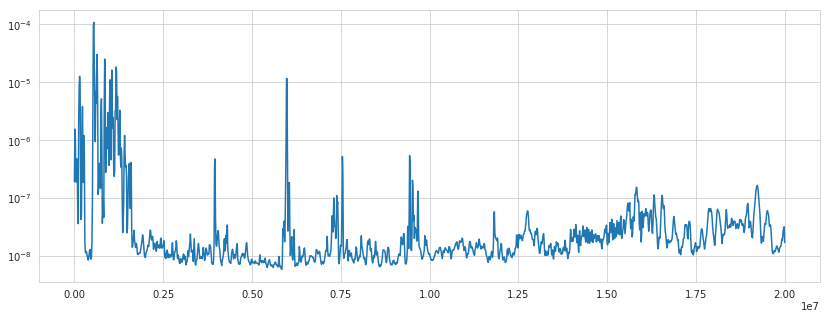

In [436]:
freqs, Pxx = sgn.welch(signal, fs=rate, window = 'hanning', nperseg = 3000, detrend = 'constant')
plt.figure(figsize = (14,5))
plt.semilogy(freqs, Pxx)
plt.show()

In [1180]:
s_id = int(362/3)
p1,p2,p3 = phase_indices(s_id)

signal = train_set.iloc[:,p1]

M = 3000
rate = 1/(2e-2/signal.size)

In [1181]:
N = signal.shape[0]

In [1316]:
%autoreload
from kit.genesis import Genesis

param_config = {
    'time_steps': 130,
    'spectrogram': {
        'freq_bins': 33
    },
    'abs_rescale':1,
    'stats': {
        'mean': 1,
        'std': 1,
        'std_top': 1,
        'std_bot': 1,
        'max_range': 1,
        'percentiles': [0, 10, 25, 50, 75, 90, 100],
        'relative_percentiles': [0, 10, 25, 50, 75, 90, 100]
    }
}

tt = Genesis(param_config = param_config)

In [1317]:
%%time
ss = transform_ts_spectrogram(signal)
Fs = transform_ts(signal, n_dim = 300)

CPU times: user 174 ms, sys: 273 µs, total: 174 ms
Wall time: 174 ms


In [1318]:
%%time
Sx_condensed = tt.generate_spectrogram(signal)
Fs = tt.generates_stat_features(tt.absolute_rescale(signal))

CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 292 ms


In [1319]:
%%time
fin_ds = tt.extract_all(signal)

CPU times: user 285 ms, sys: 0 ns, total: 285 ms
Wall time: 284 ms


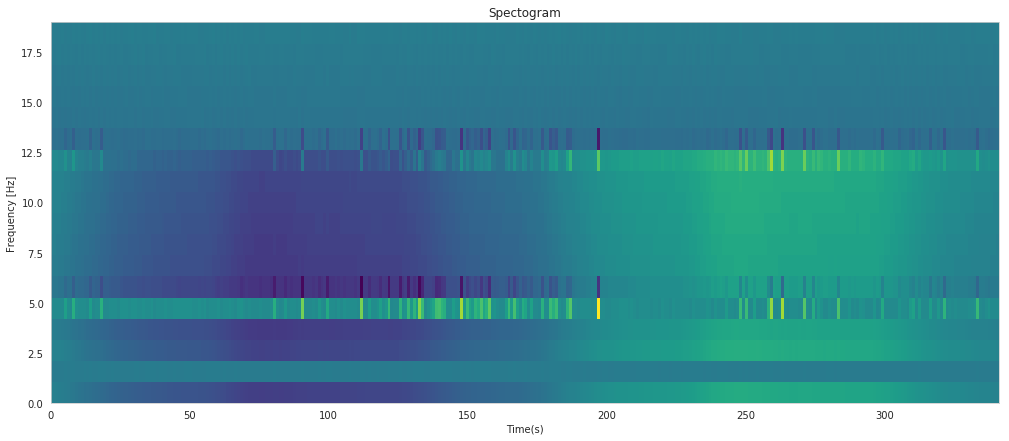

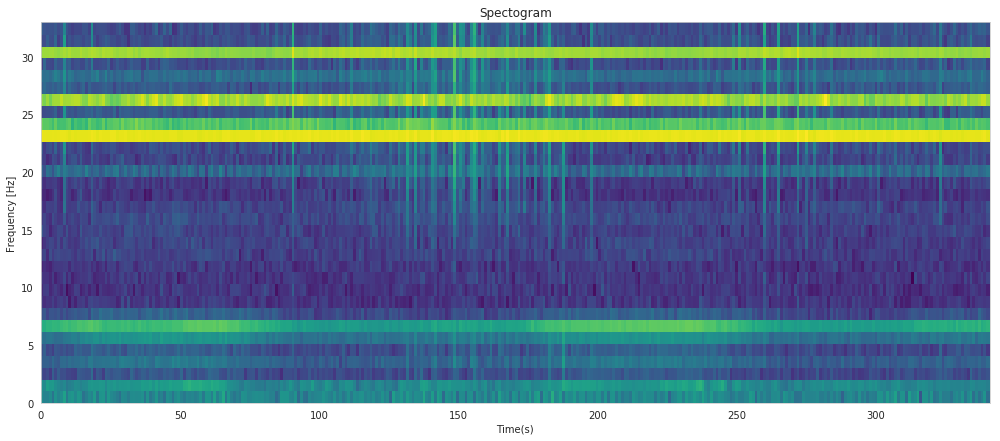

In [1278]:
x1 = np.linspace(0,Fs.shape[0],Fs.shape[0])
y1 = np.linspace(0,Fs.shape[1],Fs.shape[1])

f, ax = plt.subplots(figsize=(17, 7))
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time(s)')
ax.set_title('Spectogram')
ax.pcolormesh(x1, y1, Fs.T, cmap='viridis')
plt.show()

yy = np.linspace(0,Sx_condensed.shape[1],Sx_condensed.shape[1])
xx = np.linspace(0,Sx_condensed.shape[0],Sx_condensed.shape[0])

f, ax = plt.subplots(figsize=(17, 7))
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time(s)')
ax.set_title('Spectogram')
# ax.pcolormesh(xx,yy, Sxp.T, cmap='viridis')
ax.pcolormesh(xx,yy, Sx_condensed.T, cmap='viridis')
plt.show()

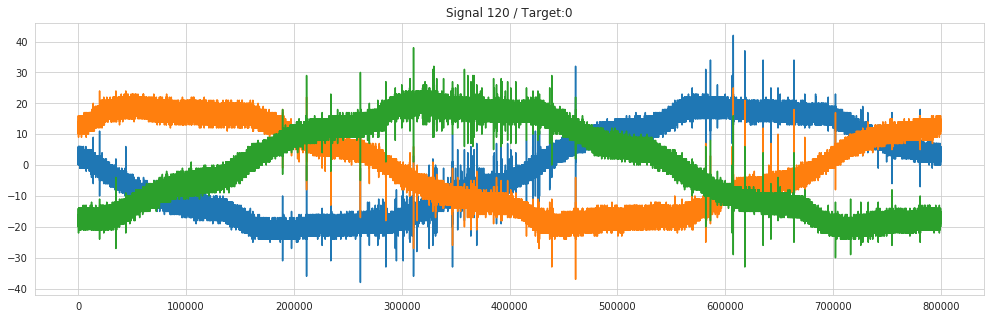

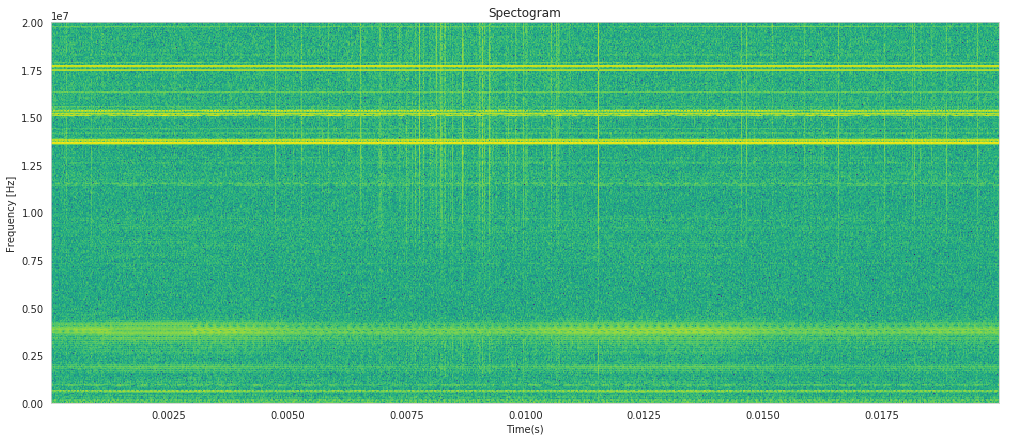

In [1279]:
freqs, times, Sx = sgn.spectrogram(signal.values, fs=rate, window='hanning',
                                      nperseg=1000, noverlap = 100,
                                      detrend='constant', scaling='spectrum')

plt.figure(figsize=(17,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(train_set.iloc[:,p1])
plt.plot(train_set.iloc[:,p2])
plt.plot(train_set.iloc[:,p3])



f, ax = plt.subplots(figsize=(17, 7))
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time(s)')
ax.set_title('Spectogram')
ax.pcolormesh(times, freqs, np.log10(Sx), cmap='viridis')
plt.show()

In [62]:
lf_signal_1 = low_pass(train_set.iloc[:,p1])
lf_signal_2 = low_pass(train_set.iloc[:,p2])
lf_signal_3 = low_pass(train_set.iloc[:,p3])

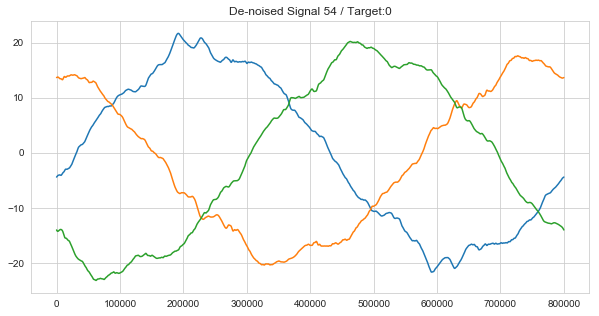

In [63]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

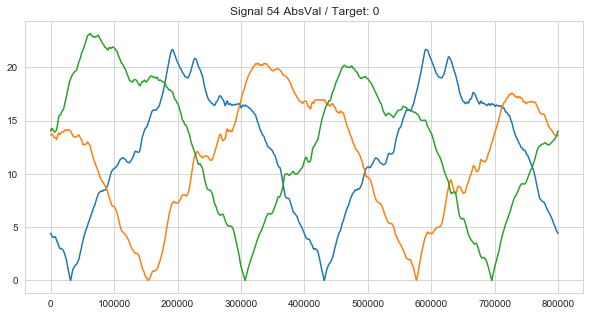

In [64]:
plt.figure(figsize=(10,5))
plt.title('Signal %d AbsVal / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(np.abs(lf_signal_1))
plt.plot(np.abs(lf_signal_2))
plt.plot(np.abs(lf_signal_3))

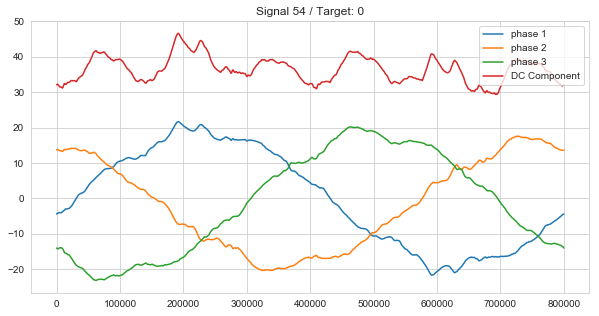

In [65]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)
plt.plot((np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)))
plt.legend(['phase 1','phase 2','phase 3','DC Component'],loc=1)

In [66]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [67]:
hf_signal_1 = high_pass(train_set.iloc[:,p1])
hf_signal_2 = high_pass(train_set.iloc[:,p2])
hf_signal_3 = high_pass(train_set.iloc[:,p3])

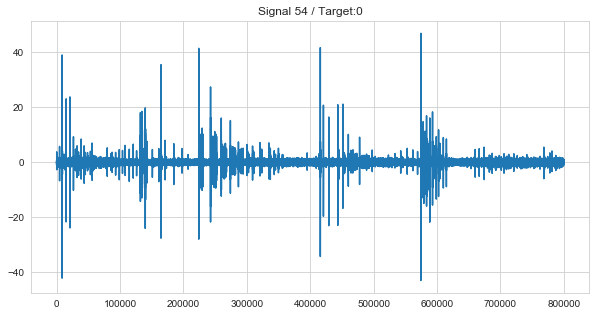

In [68]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1)
#plt.plot(hf_signal_2)
#plt.plot(hf_signal_3)

As seen above we can decouple the signals into their high and low frequency components using FFT. So the number of signal channels that are fed into the model can may very well be diversified using different decouplings in time and frequency domains. 

The mode of decoupling so far was filtering what we have to get new signals. Following part is about playing around the frequency domain to create features. 

### 4.b - Spectogram Features

In [69]:
signal = train_set.iloc[:,p1]

In [70]:
%%time
x = signal
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 1.98 ms, sys: 1.84 ms, total: 3.82 ms
Wall time: 2.65 ms


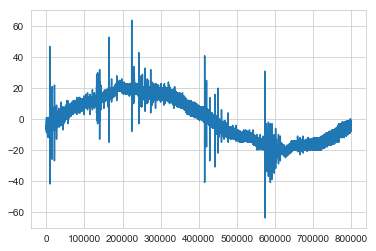

In [71]:
plt.plot(x)

<StemContainer object of 3 artists>

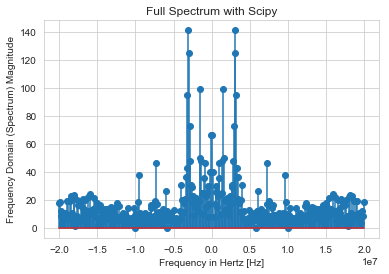

In [72]:
fig, ax = plt.subplots()
ax.set_title('Full Spectrum with Scipy')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [73]:
%%time
x = high_pass(train_set.iloc[:,p1])
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 36.2 ms, sys: 4.35 ms, total: 40.6 ms
Wall time: 38.6 ms


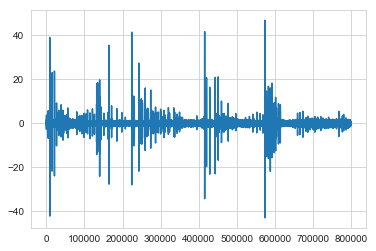

In [74]:
plt.plot(x)

<StemContainer object of 3 artists>

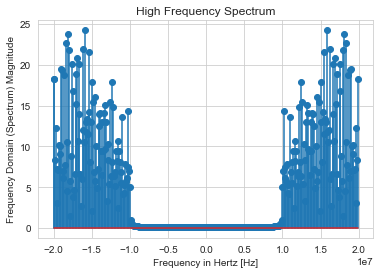

In [75]:
fig, ax = plt.subplots()
ax.set_title('High Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

In [76]:
%%time
x = low_pass(signal)
X = fftpack.fft(x,n=400)
freqs = fftpack.fftfreq(n=400,d=2e-2/x.size) 

CPU times: user 36.3 ms, sys: 4.43 ms, total: 40.8 ms
Wall time: 38.9 ms


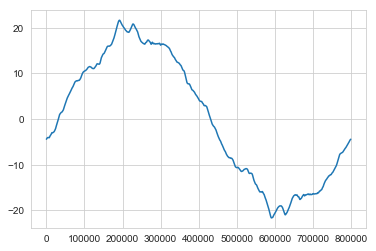

In [77]:
plt.plot(x)

<StemContainer object of 3 artists>

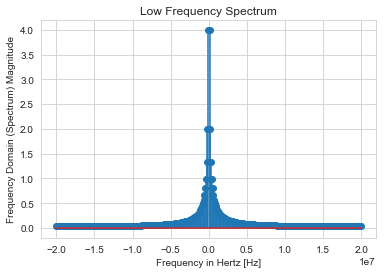

In [78]:
fig, ax = plt.subplots()
ax.set_title('Low Frequency Spectrum')
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.stem(freqs[1:], np.abs(X)[1:])

### 4.c - Frequencies vs. Time


In [6]:
p1,p2,p3 = phase_indices(100)
signal = train_set.iloc[:,p1]

NameError: name 'phase_indices' is not defined

Now we have the temporal behavior of frequencies that compose our signal in terms of their magnitudes. Aggregations can be made on both time and frequency axes by selecting appropriate window sizes.

## 5. Add Features

Apart from the signals themselves we have: 
- Low Pass Filtered Signal (800000)
- High Pass Filtered Signal (800000)
- DC component from adding absolute values of 3-phases. (800000)
- Frequency Magnitude Spectrum of full signal (400)
- Frequency Magnitude Spectrum of Low Freq signal (400)
- Frequency Magnitude Spectrum of High Freq signal (400)
- Frequency Spectrum 

For initial improvement of our model we will use diversification of signals from **4.a** and create **4 channels**:
- **Signal itself**
- **LF** component
- **HF** component
- **DC** component from three-phase merge)

The justification for DC component is that all three phase signals are rectified to form a DC behavior with a small amount of ripple. I naively assumed that a partial discharce occuring in any of the 3 signals, will result in corruption at the resulting voltage behavior. While composing up the features, each instance that belong to a triple will have the same "DC component."

In [82]:
x_train_lp = []
x_train_hp = []
x_train_dc = []
for i in meta_train.signal_id:
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    clear_output(wait=True)
    display(idx)
    hp = high_pass(train_set.iloc[:, idx[0]])
    lp = low_pass(train_set.iloc[:, idx[0]])
    meas_id = meta_train.id_measurement[meta_train.signal_id==idx].values[0]
    p1,p2,p3=phase_indices(meas_id)
    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(train_set.iloc[:,p1]), low_pass(train_set.iloc[:,p2]), low_pass(train_set.iloc[:,p3])
    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
    x_train_lp.append(abs(feature_extractor(lp, n_part=400)))
    x_train_hp.append(abs(feature_extractor(hp, n_part=400)))
    x_train_dc.append(abs(feature_extractor(dc, n_part=400)))

[8711]

In [106]:
x_train_lp.shape

(8712, 400)

In [83]:
del train_set; gc.collect()

16560

In [87]:
x_test_lp = []
x_test_hp = []
x_test_dc = []
for i in tqdm(meta_test.signal_id):
   idx = idx=i-8712
   clear_output(wait=True)
   #display(idx)
   hp = high_pass(test_set.iloc[:, idx])
   lp = low_pass(test_set.iloc[:, idx])
   meas_id = meta_test.id_measurement[meta_test.signal_id==i].values[0]
   p1,p2,p3=phase_indices(meas_id)
   lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(test_set.iloc[:,p1-8712]), low_pass(test_set.iloc[:,p2-8712]), low_pass(test_set.iloc[:,p3-8712])
   dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
   x_test_lp.append(abs(feature_extractor(lp, n_part=400)))
   x_test_hp.append(abs(feature_extractor(hp, n_part=400)))
   x_test_dc.append(abs(feature_extractor(dc, n_part=400)))

100%|██████████| 20337/20337 [1:14:21<00:00,  4.58it/s]


In [88]:
x_train = np.array(x_train).reshape(-1,x_train[0].shape[0])
x_train_lp = np.array(x_train).reshape(-1,x_train_lp[0].shape[0])
x_train_hp = np.array(x_train).reshape(-1,x_train_hp[0].shape[0])
x_train_dc = np.array(x_train).reshape(-1,x_train_dc[0].shape[0])

In [89]:
x_test = np.array(x_test).reshape(-1,x_test[0].shape[0])
x_test_lp = np.array(x_test).reshape(-1,x_test_lp[0].shape[0])
x_test_hp = np.array(x_test).reshape(-1,x_test_hp[0].shape[0])
x_test_dc = np.array(x_test).reshape(-1,x_test_dc[0].shape[0])

In [90]:
train = np.dstack((x_train,x_train_lp,x_train_hp,x_train_dc))
test = np.dstack((x_test,x_test_lp,x_test_hp,x_test_dc))

In [91]:
y_train = np.array(y_train).reshape(-1,)

In [92]:
verbose, epochs, batch_size = True, 15, 16
n_signals,n_steps, n_length = 4,40, 10
train = train.reshape((train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 8, 64)       832       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 6, 64)       12352     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [93]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [94]:
# fit network
model.fit(train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
8712/8712 [==============================] - 28s 3ms/step - loss: 0.2380 - keras_auc: 0.4920
Epoch 2/15
8712/8712 [==============================] - 28s 3ms/step - loss: 0.2120 - keras_auc: 0.5559
Epoch 3/15
8712/8712 [==============================] - 28s 3ms/step - loss: 0.1756 - keras_auc: 0.6648
Epoch 4/15
8712/8712 [==============================] - 28s 3ms/step - loss: 0.1562 - keras_auc: 0.7453
Epoch 5/15
8712/8712 [==============================] - 29s 3ms/step - loss: 0.1492 - keras_auc: 0.7909
Epoch 6/15
8712/8712 [==============================] - 30s 3ms/step - loss: 0.1364 - keras_auc: 0.8183
Epoch 7/15
8712/8712 [==============================] - 31s 4ms/step - loss: 0.1289 - keras_auc: 0.8401
Epoch 8/15
8712/8712 [==============================] - 32s 4ms/step - loss: 0.1312 - keras_auc: 0.8564
Epoch 9/15
8712/8712 [==============================] - 32s 4ms/step - loss: 0.1288 - keras_auc: 0.8668
Epoch 10/15
8712/8712 [==============================] - 33s 4ms

In [95]:
model.save_weights('model2.hdf5')

In [96]:
X_test = test.reshape((test.shape[0], n_steps, n_length, n_signals))

In [97]:
preds = model.predict(X_test)

In [98]:
threshpreds = (preds>0.5)*1

In [100]:
sub = pd.read_csv('input/sample_submission.csv')
sub.target = threshpreds

In [101]:
sub.to_csv('sub_17.csv',index=False)

### Second submission with 4 channels scores higher on LB. Increased number of epochs and playing with threshold may yield better results. I got 0.513 with re-training the model for 3+ times. 

# TODO#1: Turn Spectral Analysis into Features
# TODO#2: Enhcance the experiment with cross_val, adaptive learning rate, early stopping, ensembling etc.